<a href="https://colab.research.google.com/github/Zmuirhead03/Human-Behavior-Recognition-/blob/main/Human_Behavior_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [2]:
datasetPath = kagglehub.dataset_download("abdullaalriad/stanford-40-full")
print("Dataset Path:", datasetPath)
print(os.listdir(datasetPath))


100%|██████████| 291M/291M [00:08<00:00, 36.6MB/s]

Extracting files...


Dataset Path: /root/.cache/kagglehub/datasets/abdullaalriad/stanford-40-full/versions/1
['train_FUll']


In [3]:
rootPath = datasetPath
dataRoot = os.path.join(rootPath, "train_FUll")
print("Data Root:", dataRoot)

Data Root: /root/.cache/kagglehub/datasets/abdullaalriad/stanford-40-full/versions/1/train_FUll


In [4]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])



In [5]:
fullDataset = datasets.ImageFolder(root=dataRoot, transform=transform)
print("Number of images:", len(fullDataset))
print("Number of classes:", len(fullDataset.classes))
print("Classes (first 10):", fullDataset.classes[:10])

trainRatio = 0.8
trainSize = int(trainRatio * len(fullDataset))
valSize = len(fullDataset) - trainSize

trainDataset, valDataset = random_split(fullDataset, [trainSize, valSize])

batchSize = 32
trainLoader = DataLoader(trainDataset, batchSize, shuffle=True)
valLoader = DataLoader(valDataset, batchSize, shuffle=False)

print("Train Images:", len(trainDataset))
print("Val Images:", len(valDataset))

Number of images: 9532
Number of classes: 40
Classes (first 10): ['applauding', 'blowing_bubbles', 'brushing_teeth', 'cleaning_the_floor', 'climbing', 'cooking', 'cutting_trees', 'cutting_vegetables', 'drinking', 'feeding_a_horse']
Train Images: 7625
Val Images: 1907


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:

numClasses = len(fullDataset.classes)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
inFeatures = model.fc.in_features
model.fc = nn.Linear(inFeatures, numClasses)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [8]:
trainLossHistory = []
valLossHistory = []
trainAccHistory = []
valAccHistory = []


numEpochs = 8

for epoch in range(numEpochs):

    model.train()
    runningLoss = 0.0
    runningCorrect = 0
    runningTotal = 0

    for images, labels in trainLoader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        runningLoss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        runningCorrect += torch.sum(preds == labels).item()
        runningTotal += labels.size(0)

    trainLoss = runningLoss / float(runningTotal)
    trainAcc = runningCorrect / float(runningTotal)



    model.eval()
    valLossSum = 0.0
    valCorrect = 0
    valTotal = 0

    with torch.no_grad():
        for images, labels in valLoader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valLossSum += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            valCorrect += torch.sum(preds == labels).item()
            valTotal += labels.size(0)

    valLoss = valLossSum / float(valTotal)
    valAcc = valCorrect / float(valTotal)

    print(
        "Epoch {}/{} | Train Loss {:.4f} Acc {:.4f} | Val Loss {:.4f} Acc {:.4f}".format(
            epoch + 1,
            numEpochs,
            trainLoss,
            trainAcc,
            valLoss,
            valAcc
        )
    )
    trainLossHistory.append(trainLoss)
    valLossHistory.append(valLoss)
    trainAccHistory.append(trainAcc)
    valAccHistory.append(valAcc)


Epoch 1/8 | Train Loss 1.7891 Acc 0.5666 | Val Loss 1.0080 Acc 0.7310
Epoch 2/8 | Train Loss 0.6453 Acc 0.8597 | Val Loss 0.8397 Acc 0.7708
Epoch 3/8 | Train Loss 0.2047 Acc 0.9768 | Val Loss 0.7627 Acc 0.7840
Epoch 4/8 | Train Loss 0.0559 Acc 0.9984 | Val Loss 0.7292 Acc 0.7971
Epoch 5/8 | Train Loss 0.0222 Acc 1.0000 | Val Loss 0.7155 Acc 0.8039
Epoch 6/8 | Train Loss 0.0127 Acc 1.0000 | Val Loss 0.7028 Acc 0.8065
Epoch 7/8 | Train Loss 0.0087 Acc 1.0000 | Val Loss 0.7067 Acc 0.8023
Epoch 8/8 | Train Loss 0.0063 Acc 1.0000 | Val Loss 0.7029 Acc 0.8034


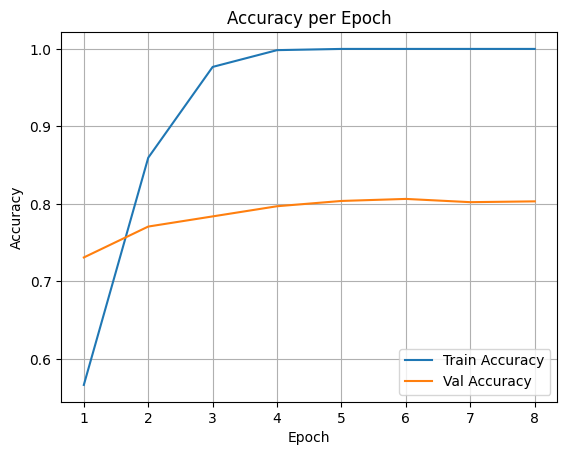

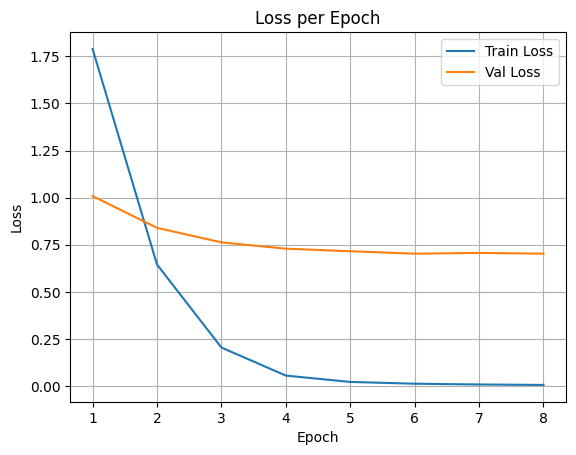

In [9]:
epochs = range(1, numEpochs + 1)


plt.figure()
plt.plot(epochs, trainAccHistory, label="Train Accuracy")
plt.plot(epochs, valAccHistory, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.plot(epochs, trainLossHistory, label="Train Loss")
plt.plot(epochs, valLossHistory, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
allLabels = []
allPreds = []

model.eval()

with torch.no_grad():
    for images, labels in valLoader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(labels.size(0)):
            labelValue = int(labels[i].cpu().item())
            predValue = int(preds[i].cpu().item())
            allLabels.append(labelValue)
            allPreds.append(predValue)


In [11]:
overallAccuracy = accuracy_score(allLabels, allPreds)
overallPrecision = precision_score(allLabels, allPreds, average="macro", zero_division=0)
overallRecall = recall_score(allLabels, allPreds, average="macro", zero_division=0)
overallF1 = f1_score(allLabels, allPreds, average="macro", zero_division=0)

print("Accuracy :", overallAccuracy)
print("Precision:", overallPrecision)
print("Recall   :", overallRecall)
print("F1 Score :", overallF1)


Accuracy : 0.8033560566334557
Precision: 0.7929434007527554
Recall   : 0.7936782329059149
F1 Score : 0.7901448355056114


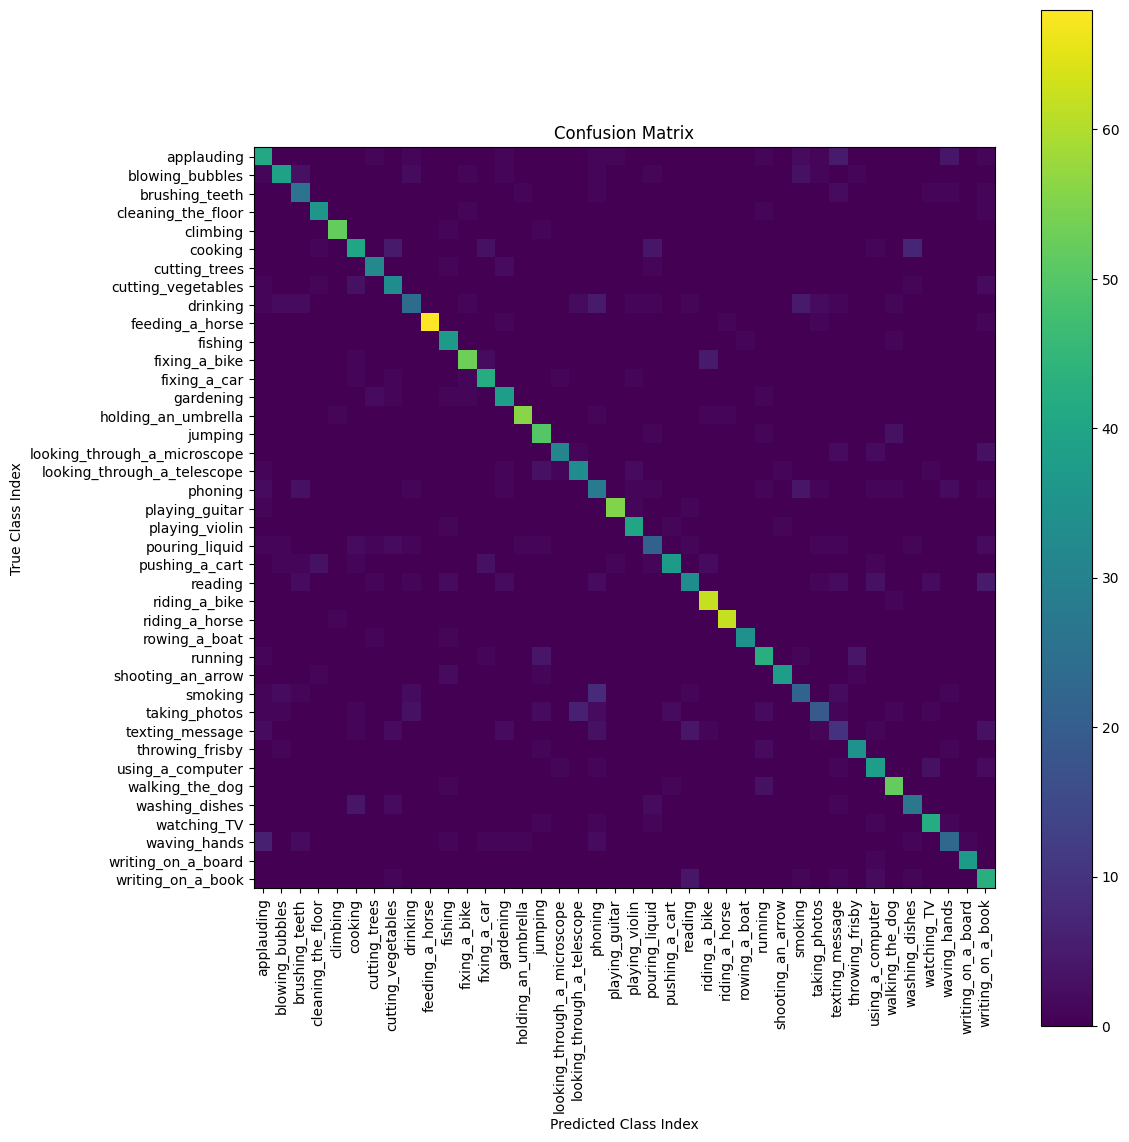

In [12]:
cm = confusion_matrix(allLabels, allPreds)

plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()

numClasses = cm.shape[0]
classNames = fullDataset.classes

tickMarks = range(numClasses)
plt.xticks(tickMarks, classNames, rotation=90)
plt.yticks(tickMarks, classNames)


plt.xlabel("Predicted Class Index")
plt.ylabel("True Class Index")

plt.tight_layout()
plt.show()


In [13]:
modelSavePath = "/content/stanford40_resnet18.pth"
torch.save(model.state_dict(), modelSavePath)
print("Model saved to:", modelSavePath)


Model saved to: /content/stanford40_resnet18.pth


Using device: cuda
Model loaded.


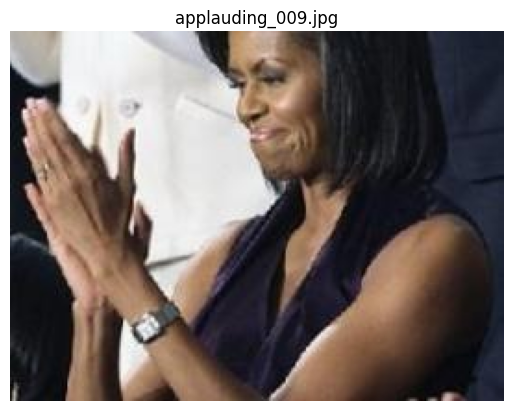

Predicted Behavior:  texting_message


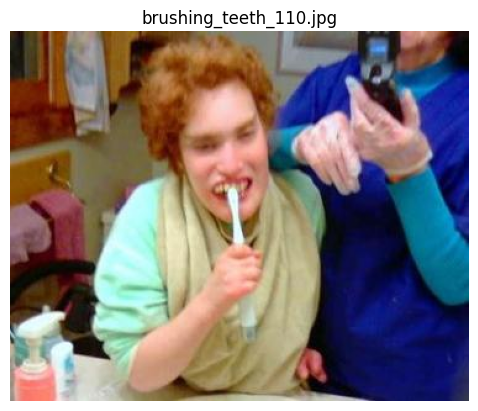

Predicted Behavior:  brushing_teeth


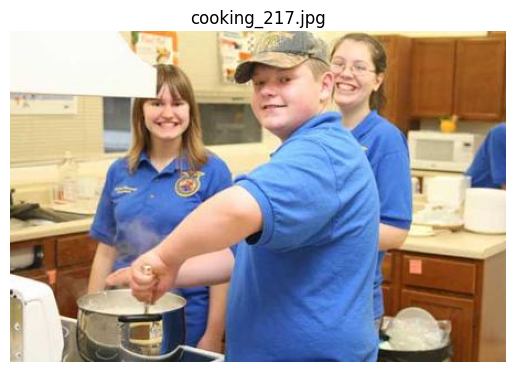

Predicted Behavior:  pouring_liquid


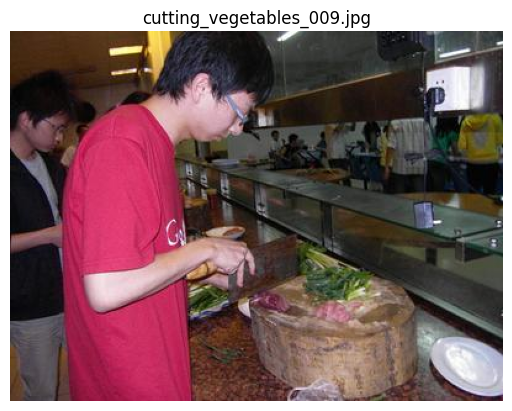

Predicted Behavior:  cutting_vegetables


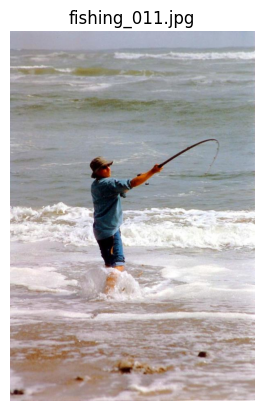

Predicted Behavior:  fishing


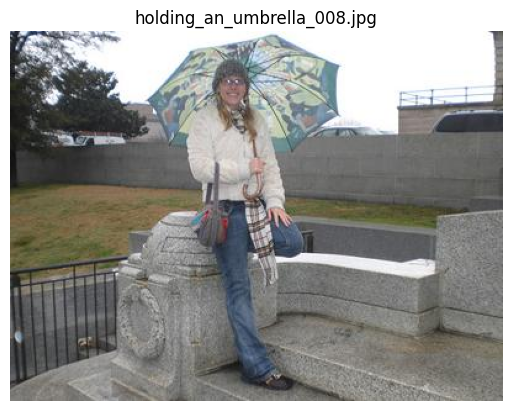

Predicted Behavior:  holding_an_umbrella


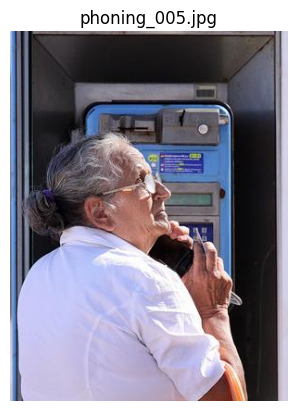

Predicted Behavior:  phoning


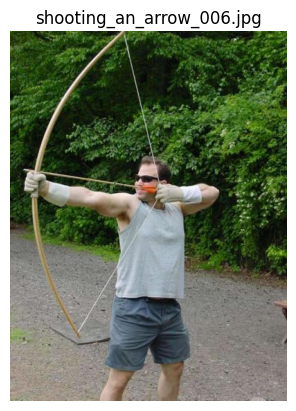

Predicted Behavior:  shooting_an_arrow


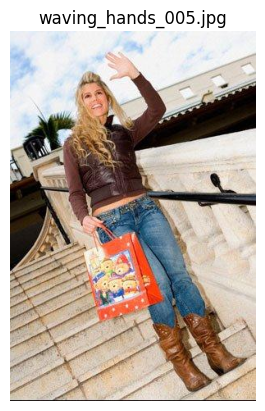

Predicted Behavior:  waving_hands


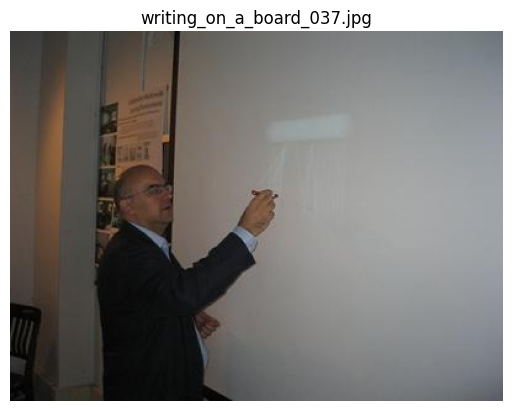

Predicted Behavior:  writing_on_a_board


In [15]:
imagesFolder = "/content/behaviorTetsImages"
modelPath = "/content/stanford40_resnet18.pth"

classNames = [
    'applauding', 'blowing_bubbles', 'brushing_teeth', 'cleaning_the_floor',
    'climbing', 'cooking', 'cutting_trees', 'cutting_vegetables',
    'drinking', 'feeding_a_horse', 'fishing', 'fixing_a_bike',
    'fixing_a_car', 'gardening', 'holding_an_umbrella',
    'jumping', 'looking_through_a_microscope',
    'looking_through_a_telescope', 'phoning', 'playing_guitar',
    'playing_violin', 'pouring_liquid', 'pushing_a_cart', 'reading',
    'riding_a_bike', 'riding_a_horse', 'rowing_a_boat', 'running',
    'shooting_an_arrow', 'smoking', 'taking_photos', 'texting_message',
    'throwing_frisby', 'using_a_computer', 'walking_the_dog',
    'washing_dishes', 'watching_TV', 'waving_hands',
    'writing_on_a_board', 'writing_on_a_book'
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

numClasses = len(classNames)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
inFeatures = model.fc.in_features
model.fc = nn.Linear(inFeatures, numClasses)
model.load_state_dict(torch.load(modelPath, map_location=device))

model = model.to(device)
model.eval()

print("Model loaded.")

validExts = [".jpg", ".jpeg", ".png", ".bmp"]

for filename in sorted(os.listdir(imagesFolder)):
    lowerName = filename.lower()
    isImage = False

    for ext in validExts:
        if lowerName.endswith(ext):
            isImage = True

    if not isImage:
        continue

    imgPath = os.path.join(imagesFolder, filename)
    img = Image.open(imgPath).convert("RGB")

    x = transform(img)
    x = x.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predIdx = torch.max(outputs, 1)
        predIdx = predIdx.item()
        predLabel = classNames[predIdx]
    plt.imshow(img)
    plt.title(filename)
    plt.axis('off')
    plt.show()
    print("Predicted Behavior: " , predLabel)
